In [3]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn . model_selection import train_test_split
from sklearn . preprocessing import LabelEncoder , OneHotEncoder
from sklearn . metrics import confusion_matrix ,classification_report
import matplotlib . pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
# Fonctions d’activation
def relu (x ):
    """
    ReLU activation : max (0 , x)
    """
    assert isinstance (x , np . ndarray ) , " Input to ReLU must be a numpy array "
    result = np . maximum (0 , x)
    assert np . all ( result >= 0) , " ReLU output must be non - negative "
    return result

def relu_derivative ( x) :
    """
    Derivative of ReLU : 1 if x > 0 , else 0
    """
    assert isinstance (x , np . ndarray ) , " Input to ReLU derivative must be a numpy array "
    result = np . where (x > 0 , 1 , 0)
    assert np . all (( result == 0) | ( result == 1) ) , " ReLU derivativemust be 0 or 1"
    return result
    
def softmax ( x):
    """
    Softmax activation : exp (x) / sum ( exp (x))
    """
    assert isinstance (x , np . ndarray ) , " Input to softmax must be a numpy array "
    exp_x = np . exp ( x - np . max ( x , axis =1 , keepdims = True ))

    result = exp_x / np .sum ( exp_x , axis =1 , keepdims = True )
    assert np . all (( result >= 0) & ( result <= 1) ) , " Softmax output must be in [0 , 1]"
    
    assert np . allclose ( np .sum ( result , axis =1) , 1) , " Softmax output sum to 1 per sample "
    
    return result

In [5]:
# Classe MultiClassNeuralNetwork
class MultiClassNeuralNetwork:
    def __init__(self , layer_sizes , model_optimization,learning_rate =0.01):
        """
        Initialize the neural network with given layer sizes and
        learning rate.
        layer_sizes: List of integers [input_size , hidden1_size ,
        ..., output_size]
        """
        assert isinstance(layer_sizes , list) and len(layer_sizes)>= 2, "layer_sizes must be a list with at least 2elements"
        assert all(isinstance(size , int) and size > 0 for size in layer_sizes), "All layer sizes must be positive integers"
        assert isinstance(learning_rate , (int , float)) and learning_rate > 0, "Learning rate must be a positivenumber"

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.model_optimization=model_optimization


        # Initialisation des poids et biais
        np.random.seed (42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1])* 0.01
            b = np.zeros((1, layer_sizes[i+1]))
            assert w.shape == (layer_sizes[i], layer_sizes[i+1]),f"Weight matrix {i+1} has incorrect shape"
            assert b.shape == (1, layer_sizes[i+1]), f"Bias vector{i+1} has incorrect shape"
            self.weights.append(w)
            self.biases.append(b)
            # Initialisation des variables pour l'optimiseur Adam APRÈS l'initialisation des poids et biais
        self.m_w = [np.zeros_like(w) for w in self.weights]
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.m_b = [np.zeros_like(b) for b in self.biases]
        self.v_b = [np.zeros_like(b) for b in self.biases]
        self.t = 0 # time step
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8 # une variable epsilon pour eviter la division sur 0

    def forward(self , X):
        """
        Forward propagation: Z^{[l]} = A^{[l-1]} W^{[l]} + b^{[l]}, A^{[l]} = g(Z^{[l]})
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape [1] == self.layer_sizes [0], f"Input dimension ({X.shape [1]}) must match input layer size ({self.layer_sizes [0]})"
        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[-1],self.weights[i])+self.biases[i]
            assert z.shape == (X.shape[0], self.layer_sizes[i+1]),f"Z^{[i+1]} has incorrect shape"
            self.z_values.append(z)
            self.activations.append(relu(z))

        z=np.dot(self.activations[-1],self.weights[-1])+self.biases[-1]

        assert z.shape == (X.shape[0], self.layer_sizes [-1]), "Output Z has incorrect shape"
        self.z_values.append(z)
        
        output = softmax(z)
        assert output.shape == (X.shape[0], self.layer_sizes [-1]),"Output A has incorrect shape"
        self.activations.append(output)

        return self.activations [-1]

    def compute_loss(self , y_true , y_pred):
        """
        Categorical Cross -Entropy: J = -1/m * sum(y_true * log(y_pred))
        """
        assert isinstance(y_true , np.ndarray) and isinstance(y_pred , np.ndarray), "Inputs to loss must be numpy arrays"

        assert y_true.shape == y_pred.shape , "y_true and y_pred must have the same shape"

        y_pred = np.clip(y_pred , 1e-15, 1 - 1e-15)
        m = y_true . shape [0]

        loss = (-1/m)*np.sum(y_true*np.log(y_pred))
        assert not np.isnan(loss), "Loss computation resulted in NaN"
                             
        return loss 

    def compute_accuracy(self , y_true , y_pred):
        """
        Compute accuracy: proportion of correct predictions
        """
        assert isinstance(y_true , np.ndarray) and isinstance(y_pred , np.ndarray), "Inputs to accuracy must be numpy arrays"

        assert y_true.shape == y_pred.shape , "y_true and y_pred must have the same shape"

        predictions = np.argmax(y_pred , axis =1)

        true_labels = np.argmax(y_true , axis =1)
        accuracy = np.mean(predictions == true_labels)
        assert 0 <= accuracy <= 1, "Accuracy must be between 0 and 1"
        return accuracy

    def backward(self , X, y, outputs):
        """
        Backpropagation: compute dW^{[l]}, db^{[l]} for each layer
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(outputs , np.ndarray), "Inputs to backward must be numpy arrays"

        assert X.shape [1] == self.layer_sizes [0], f"Input dimension ({X.shape [1]}) must match input layer size ({self.layer_sizes [0]})"

        assert y.shape == outputs.shape , "y and outputs must have the same shape"

        m = X.shape [0]
        self.d_weights = [ np . zeros_like (w ) for w in self . weights ]
        self.d_biases = [ np . zeros_like ( b) for b in self . biases ]

        dZ = outputs - y # Gradient pour softmax + cross -entropy
       

        
        assert dZ.shape == outputs.shape , "dZ for output layer has incorrect shape"
        self.d_weights [-1] = (self.activations [-2].T @ dZ) / m
        self.d_biases [-1] = np.sum(dZ, axis=0, keepdims=True) / m

        for i in range(len(self.weights) - 2, -1, -1):
            # dZ = np.dot(dZ[i+1],self.weights[i+1].T)*relu_derivative(self.z_values[i])#TODO
            dZ = dZ @ self.weights[i+1].T
            dZ = dZ * relu_derivative(self.z_values[i])
            assert dZ.shape == (X.shape[0], self.layer_sizes[i+1]), f"dZ^{[i+1]} has incorrect shape"
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

        # TODO: Ajouter une r gularisation L2 aux gradients des poids

        # dW^{[l]} += lambda * W^{[l]} / m, o lambda est le coefficient de r gularisation
        lamda=0.1
        for i in range(len(self.weights)):
            self.d_weights[i]+=lamda*self.weights[i]/m
        

        if self.model_optimization == "SGD":
            # calcule avec gradient descent stochastic
            for i in range (len ( self . weights )) :
              self. weights [ i] -= self . learning_rate * self . d_weights [ i]
              self . biases [ i] -= self . learning_rate * self . d_biases [ i]
        elif self.model_optimization == "Adam":
            # calcule avec Adam
            self.t += 1 # Increment time step per batch
    
            for i in range (len ( self . weights )) :
                # Mise à jour des moments
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * self.d_weights[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (self.d_weights[i]**2)
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * self.d_biases[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (self.d_biases[i]**2)
    
                # Correctif de biais
                m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)# mise à jour du 1er moment (momentum)
                v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)# mise à jour du 2e moment (RMS)
                m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)# mise à jour du 1er moment (momentum) (sur le biais)
                v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)# mise à jour du 2e moment (RMS)(sur le biais)
    
                # Update des paramètres
                self . weights [ i] -= self . learning_rate  * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
                self . biases [ i] -= self . learning_rate  * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)






    def train(self , X, y, X_val , y_val , epochs , batch_size):
        """
        Train the neural network using mini -batch SGD , with validation
        """
        assert isinstance(X, np.ndarray) and isinstance(y, np.ndarray), "X and y must be numpy arrays"
        assert isinstance(X_val , np.ndarray) and isinstance(y_val ,np.ndarray), "X_val and y_val must be numpy arrays"

        assert X.shape [1] == self.layer_sizes [0], f"Input dimension ({X.shape [1]}) must match input layer size ({self.layer_sizes [0]})"
        assert y.shape [1] == self.layer_sizes [-1], f"Output dimension ({y.shape [1]}) must match output layer size({self.layer_sizes [-1]})"
        assert X_val.shape [1] == self.layer_sizes [0], f"Validation input dimension ({X_val.shape [1]}) must match input layer size ({self.layer_sizes [0]})"
        assert y_val.shape [1] == self.layer_sizes [-1], f"Validation output dimension ({y_val.shape [1]}) must match output layer size ({self.layer_sizes [-1]})"
        assert isinstance(epochs , int) and epochs > 0, "Epochs must be a positive integer"
        assert isinstance(batch_size , int) and batch_size > 0, "Batch size must be a positive integer"

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            indices = np.random.permutation(X.shape [0])
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            epoch_loss = 0
            for i in range(0, X.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch , outputs)
                self.backward(X_batch , y_batch , outputs)

            # Calculer les pertes et accuracies
            train_loss = epoch_loss / (X.shape [0] // batch_size)
            train_pred = self.forward(X)
            train_accuracy = self.compute_accuracy(y, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val , val_pred)
            val_accuracy = self.compute_accuracy(y_val , val_pred)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss :.4f}, Val Loss: {val_loss :.4f}, "f"Train Acc: {train_accuracy :.4f}, Val Acc:{val_accuracy :.4f}")

        return train_losses , val_losses , train_accuracies ,val_accuracies

    def predict(self , X):
        """
        Predict class labels
        """
        assert isinstance(X, np.ndarray), "Input X must be a numpy array"
        assert X.shape [1] == self.layer_sizes [0], f"Input dimension ({X.shape [1]}) must match input layer size ({self.layer_sizes [0]})"

        outputs = self.forward(X)
        predictions = np.argmax(outputs , axis =1)
        assert predictions.shape == (X.shape[0],), "Predictions have incorrect shape"
        return predictions


In [55]:
import os
import sys

# 1) À adapter à vos chemins
latin_labels_txt    = '/Users/hicham/Downloads/AMHCD_64/labels/labels/33-common-latin-tifinagh.txt'
tifinagh_labels_txt = '/Users/hicham/Downloads/AMHCD_64/labels/labels/sorted-33-common-tifinagh.txt'
images_root         = '/Users/hicham/Downloads/AMHCD_64/AMHCD_64/AMHCD_64'
output_csv          = '/Users/hicham/Downloads/AMHCD_64/AMHCD_64/AMHCD_64/new-labels-map.csv'

# 2) Lire les labels Latin et les glyphes Tifinagh
with open(latin_labels_txt, 'r', encoding='utf-8') as f:
    ascii_labels = [line.strip() for line in f if line.strip()]

with open(tifinagh_labels_txt, 'r', encoding='utf-8') as f:
    tif_chars = [line.strip() for line in f if line.strip()]

# 3) Vérification  
if len(ascii_labels) != len(tif_chars):
    print(f"❌ Erreur : {len(ascii_labels)} labels Latin ≠ {len(tif_chars)} glyphes Tifinagh")
    sys.exit(1)

# 4) Génération du CSV
with open(output_csv, 'w', encoding='utf-8', newline='') as out:
    for latin, tif in zip(ascii_labels, tif_chars):
        folder = os.path.join(images_root, latin)
        if not os.path.isdir(folder):
            print(f"⚠️ Dossier introuvable, je passe : {folder}")
            continue
        for fname in sorted(os.listdir(folder)):
            # filtrer si nécessaire par extension d’image
            if not fname.lower().endswith(('.png','.jpg','.jpeg','.bmp','.tif','.tiff')):
                continue
            rel_path = f"./AMHCD_64/AMHCD_64/AMHCD_64/{latin}/{fname}"
            # Écrire UNE ligne contenant chemin + glyphe
            out.write(f"{rel_path},{tif}\n")

print(f"✅ Généré {output_csv} avec {sum(len(os.listdir(os.path.join(images_root,l))) for l in ascii_labels if os.path.isdir(os.path.join(images_root,l)))} entrées.")


✅ Généré /Users/hicham/Downloads/new-labels-map.csv avec 25740 entrées.


✅ Chargé 25740 images, 33 classes.
Train=15444, Val=5148, Test=5148
Epoch 0, Train Loss: 3.5113, Val Loss: 3.4965, Train Acc: 0.0303, Val Acc:0.0303
Epoch 10, Train Loss: 2.7198, Val Loss: 2.6771, Train Acc: 0.1204, Val Acc:0.1189
Epoch 20, Train Loss: 2.4338, Val Loss: 2.3593, Train Acc: 0.2558, Val Acc:0.2514
Epoch 30, Train Loss: 1.9566, Val Loss: 1.9200, Train Acc: 0.3633, Val Acc:0.3648
Epoch 40, Train Loss: 1.6343, Val Loss: 1.5893, Train Acc: 0.4902, Val Acc:0.4810
Epoch 50, Train Loss: 1.3536, Val Loss: 1.3107, Train Acc: 0.5853, Val Acc:0.5831
Epoch 60, Train Loss: 1.2274, Val Loss: 1.2512, Train Acc: 0.6095, Val Acc:0.6016
Epoch 70, Train Loss: 1.0498, Val Loss: 1.0708, Train Acc: 0.6689, Val Acc:0.6577
Epoch 80, Train Loss: 0.8940, Val Loss: 1.0400, Train Acc: 0.6726, Val Acc:0.6647
Epoch 90, Train Loss: 0.7957, Val Loss: 0.8082, Train Acc: 0.7755, Val Acc:0.7622

=== Classification Report (Test) ===
              precision    recall  f1-score   support

           ⴰ       0

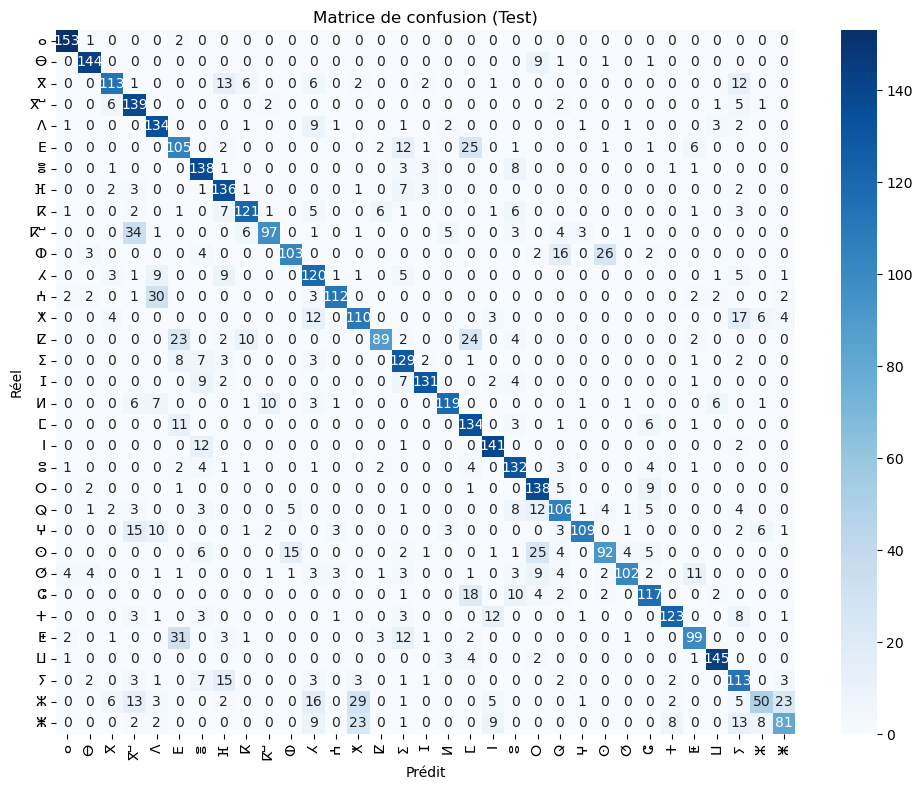

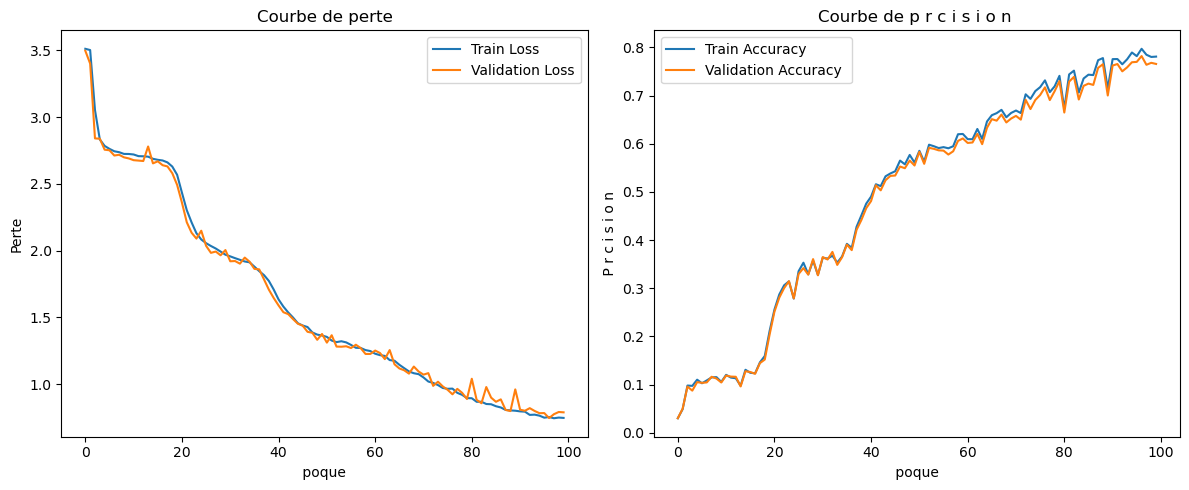

In [13]:
import os
import pandas as pd
import numpy as np
import cv2
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1) dossier racine
data_dir = '/Users/hicham/Downloads/AMHCD_64/AMHCD_64/AMHCD_64'
csv_path = os.path.join(data_dir, 'new-labels-map.csv')

# 2) lire le CSV (rel_path + glyphe UTF-8)
df = pd.read_csv(
    csv_path,
    header=None,
    names=['rel_path', 'glyph'],
    dtype=str,
    encoding='utf-8'
)

# 3) NORMALISATION des chemins : ne garder que label/filename
def make_full_path(rel_p):
    p = Path(rel_p.lstrip('./'))           # supprime un "./" initial
    sub = p.parts[-2:]                     # ne garder que les 2 derniers segments
    return os.path.join(data_dir, *sub)

df['image_path'] = df['rel_path'].apply(make_full_path)

# 4) vérification d’existence
missing = df.loc[~df['image_path'].apply(os.path.exists), 'image_path']
if not missing.empty:
    raise FileNotFoundError("Fichiers introuvables :\n" + "\n".join(missing.tolist()))
print(f"✅ Chargé {len(df)} images, {df['glyph'].nunique()} classes.")

# 5) encoder les glyphes en entiers
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['glyph'])
num_classes = len(le.classes_)

# 6) fonction de chargement et prétraitement
def load_and_preprocess(path, target_size=(32,32)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise IOError(f"Impossible de charger : {path}")
    img = cv2.resize(img, target_size)
    return (img.astype(np.float32) / 255.0).flatten()

# 7) construire X et y
X = np.stack([load_and_preprocess(p) for p in df['image_path']])
y = df['label_enc'].values

# 8) split train/val/test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42
)
print(f"Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# 9) one-hot encoding pour l’entraînement
ohe = OneHotEncoder(sparse_output=False)
y_train_1h = ohe.fit_transform(y_train.reshape(-1,1))
y_val_1h   = ohe.transform(y_val.reshape(-1,1))




# 10) entraîner le modèle
layers = [X_train.shape[1], 64, 32, num_classes]
nn = MultiClassNeuralNetwork(layers, model_optimization="Adam", learning_rate=0.001)
train_losses, val_losses, train_acc, val_acc = nn.train(
    X_train, y_train_1h,
    X_val,   y_val_1h,
    epochs=100, batch_size=64
)

# 11) évaluer sur test
y_pred = nn.predict(X_test)
print("\n=== Classification Report (Test) ===")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Matrice de confusion (Test)')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
# Courbes de perte et d’accuracy
fig , (ax1 , ax2) = plt.subplots(1, 2, figsize =(12, 5))

# Courbe de perte
ax1.plot(train_losses , label='Train Loss')
ax1.plot(val_losses , label='Validation Loss')
ax1.set_title('Courbe de perte')
ax1.set_xlabel(' poque ')
ax1.set_ylabel('Perte')
ax1.legend ()

# Courbe d’accuracy
ax2.plot(train_acc , label='Train Accuracy ')
ax2.plot(val_acc , label='Validation Accuracy ')
ax2.set_title('Courbe de p r c i s i o n ')
ax2.set_xlabel(' poque ')
ax2.set_ylabel(' P r c i s i o n ')
ax2.legend ()

plt.tight_layout ()
fig.savefig('loss_accuracy_plot.png')
plt.show()


Testing learning_rate=0.001, batch_size=128 ...
Epoch 0, Train Loss: 3.4930, Val Loss: 3.2454, Train Acc: 0.0567, Val Acc:0.0619
Epoch 10, Train Loss: 2.7214, Val Loss: 2.6946, Train Acc: 0.1109, Val Acc:0.1037
Epoch 20, Train Loss: 2.2348, Val Loss: 2.2012, Train Acc: 0.2764, Val Acc:0.2824
Epoch 30, Train Loss: 1.8074, Val Loss: 1.7464, Train Acc: 0.4362, Val Acc:0.4428
Epoch 40, Train Loss: 1.2435, Val Loss: 1.2428, Train Acc: 0.6267, Val Acc:0.6312
Epoch 50, Train Loss: 0.8372, Val Loss: 0.8098, Train Acc: 0.7772, Val Acc:0.7822
Epoch 60, Train Loss: 0.7019, Val Loss: 0.7325, Train Acc: 0.8024, Val Acc:0.7883
Epoch 70, Train Loss: 0.6040, Val Loss: 0.6037, Train Acc: 0.8430, Val Acc:0.8318
Epoch 80, Train Loss: 0.5192, Val Loss: 0.5848, Train Acc: 0.8529, Val Acc:0.8407
Epoch 90, Train Loss: 0.4974, Val Loss: 0.5362, Train Acc: 0.8703, Val Acc:0.8517
Epoch 0, Train Loss: 3.4731, Val Loss: 3.1756, Train Acc: 0.0761, Val Acc:0.0702
Epoch 10, Train Loss: 2.5999, Val Loss: 2.5578, Trai

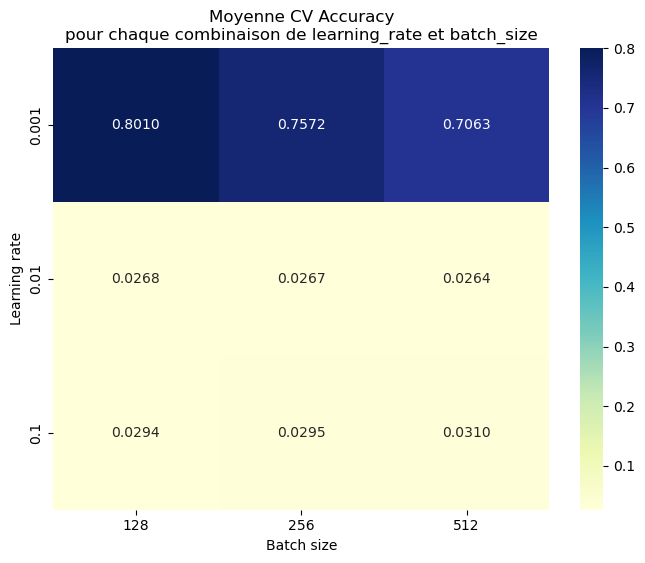

Epoch 0, Train Loss: 3.5187, Val Loss: 3.4964, Train Acc: 0.0313, Val Acc:0.0313
Epoch 10, Train Loss: 2.3794, Val Loss: 2.2478, Train Acc: 0.2615, Val Acc:0.2615
Epoch 20, Train Loss: 1.5342, Val Loss: 1.4844, Train Acc: 0.5267, Val Acc:0.5267
Epoch 30, Train Loss: 1.3581, Val Loss: 1.3288, Train Acc: 0.5867, Val Acc:0.5867
Epoch 40, Train Loss: 1.2696, Val Loss: 1.2491, Train Acc: 0.6115, Val Acc:0.6115
Epoch 50, Train Loss: 1.0443, Val Loss: 1.1130, Train Acc: 0.6373, Val Acc:0.6373
Epoch 60, Train Loss: 0.9439, Val Loss: 0.9505, Train Acc: 0.7115, Val Acc:0.7115
Epoch 70, Train Loss: 0.8606, Val Loss: 0.8447, Train Acc: 0.7534, Val Acc:0.7534
Epoch 80, Train Loss: 0.7533, Val Loss: 0.7199, Train Acc: 0.7951, Val Acc:0.7951
Epoch 90, Train Loss: 0.6410, Val Loss: 0.6745, Train Acc: 0.8007, Val Acc:0.8007

Rapport de classification (Test set) avec la meilleure combinaison :
              precision    recall  f1-score   support

          ya       0.97      0.99      0.98       156
  

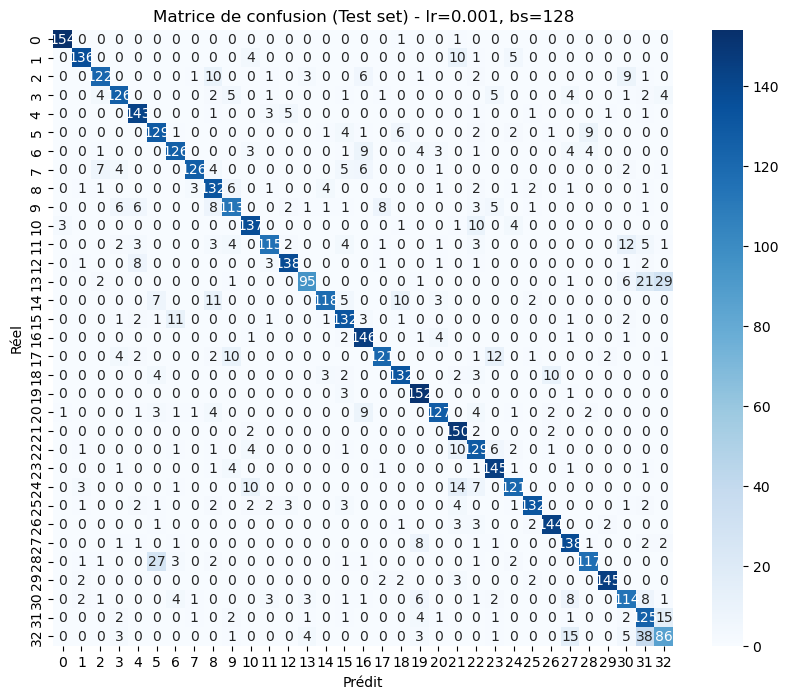

In [85]:
# ----- Définir les hyperparamètres à tester -----
learning_rates = [0.001, 0.01, 0.1]
batch_sizes    = [128, 256, 512]
n_splits       = 5

# Préparer un tableau pour stocker la performance moyenne (accuracy) pour chaque combinaison
mean_val_accuracy = np.zeros((len(learning_rates), len(batch_sizes)))

# ----- Créer une version one-hot de y_temp pour la CV -----
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_temp_one_hot = one_hot_encoder.fit_transform(y_temp.reshape(-1, 1))
assert y_temp_one_hot.shape[0] == X_temp.shape[0] and y_temp_one_hot.shape[1] == num_classes
# Boucle de recherche par cross-validation sur chaque combinaison de hyperparamètres


for i, lr in enumerate(learning_rates):
    for j, bs in enumerate(batch_sizes):
        print(f"Testing learning_rate={lr}, batch_size={bs} ...")
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_accuracies = []

        for train_index, val_index in kf.split(X_temp):
            X_train_fold = X_temp[train_index]
            X_val_fold   = X_temp[val_index]
            y_train_fold = y_temp_one_hot[train_index]
            y_val_fold   = y_temp_one_hot[val_index]

            # Initialiser un nouveau modèle avec le learning rate courant
            layer_sizes = [X_train_fold.shape[1], 64, 32, num_classes]
            nn = MultiClassNeuralNetwork(layer_sizes, model_optimization="Adam",learning_rate=lr)

            # Entraîner sur ce fold
            _, val_losses, _, val_accs = nn.train(
                X_train_fold, y_train_fold,
                X_val_fold,   y_val_fold,
                epochs=100, batch_size=bs
            )

            # Récupérer la dernière accuracy du fold de validation
            fold_accuracies.append(val_accs[-1])

        # Calculer la moyenne des accuracies sur les n_splits folds
        mean_val_accuracy[i, j] = np.mean(fold_accuracies)
        print(f"→ Moyenne CV accuracy pour lr={lr}, bs={bs} : {mean_val_accuracy[i, j]:.4f}")

# Déterminer la combinaison qui a la performance la plus élevée
best_idx = np.unravel_index(np.argmax(mean_val_accuracy), mean_val_accuracy.shape)
best_lr  = learning_rates[best_idx[0]]
best_bs  = batch_sizes[best_idx[1]]
best_acc = mean_val_accuracy[best_idx]
print(f"\nMeilleure combinaison : learning_rate={best_lr}, batch_size={best_bs} avec CV accuracy={best_acc:.4f}")

# ----- Visualisation des résultats sous forme de heatmap -----
plt.figure(figsize=(8, 6))
sns.heatmap(
    mean_val_accuracy,
    annot=True, fmt=".4f",
    xticklabels=batch_sizes,
    yticklabels=learning_rates,
    cmap="YlGnBu"
)
plt.title("Moyenne CV Accuracy\npour chaque combinaison de learning_rate et batch_size")
plt.xlabel("Batch size")
plt.ylabel("Learning rate")
plt.savefig("cv_accuracy_heatmap.png")
plt.show()

# ----- Réentraîner un modèle final sur tout X_temp avec la meilleure combinaison -----
layer_sizes_final = [X_temp.shape[1], 64, 32, num_classes]
nn_final = MultiClassNeuralNetwork(layer_sizes_final,  model_optimization="Adam",learning_rate=best_lr)
# Reconstruire y_temp_one_hot si nécessaire :
# y_temp_one_hot = one_hot_encoder.fit_transform(y_temp.reshape(-1, 1))
nn_final.train(X_temp, y_temp_one_hot, X_temp, y_temp_one_hot, epochs=100, batch_size=best_bs)

# ----- Évaluer le modèle final sur le jeu de test -----
y_test_pred = nn_final.predict(X_test)
print("\nRapport de classification (Test set) avec la meilleure combinaison :")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# Matrice de confusion (Test set)
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matrice de confusion (Test set) - lr={best_lr}, bs={best_bs}")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.savefig("confusion_matrix_best.png")
plt.show()